In [137]:
import os
import random
import sys
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from core.generator import gen_step, gen_u_daily_sine
from core.lettuce_model import _lettuce_growth_model, lettuce_growth_model
from core.plot import plot_response, plot_states
from core.simulate import simulate

random.seed(40)

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Setup Google Colab Environment
if "google.colab" in sys.modules:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    os.chdir(userdata.get("project_path"))
    !git pull
    !git checkout dev
    !git pull
    %pip install -r requirements-dev.txt
    !pre-commit install --hook-type pre-push

In [ ]:
# Commit changes
if "google.colab" in sys.modules:
    !git add -A
    name = userdata.get("github_name")
    email = userdata.get("github_email")
    !git -c user.name="$name" user.email="$email" commit -m "FIX: Githu"

In [ ]:
# Push changes to GitHub
if "google.colab" in sys.modules:
    token = userdata.get("github_token")
    !git push https://$token@github.com/MarekWadinger/dynamic_opt_growth_model.git

In [31]:
x0 = [0.72, 2.7]  # Vanhenten 1994
u_min = [10, 0, 400]
u_max = [25, 100, 800]

In [35]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0
)

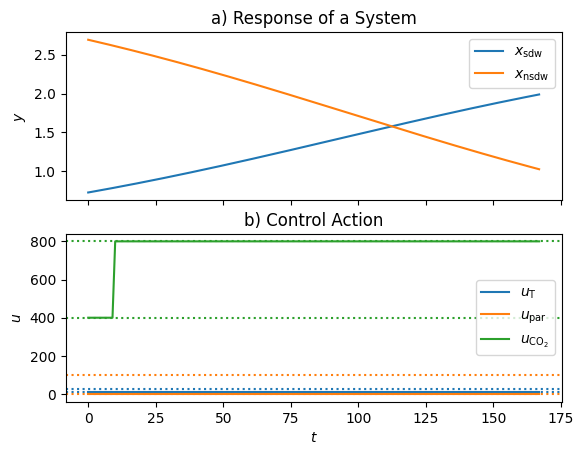

In [125]:
plot_response(t_out, y_out, u_out, u_min=u_min, u_max=u_max)
plt.show()

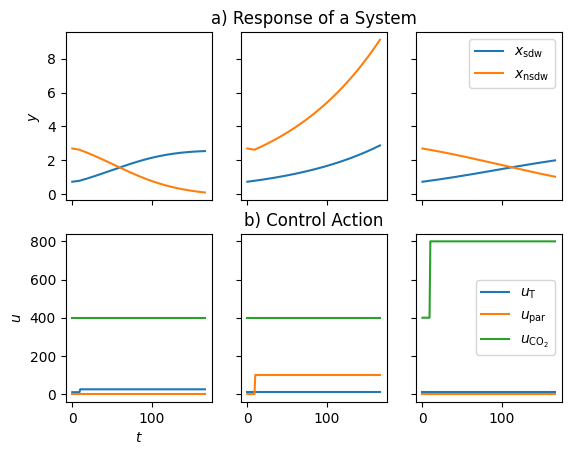

In [127]:
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 2].legend()

plt.show()

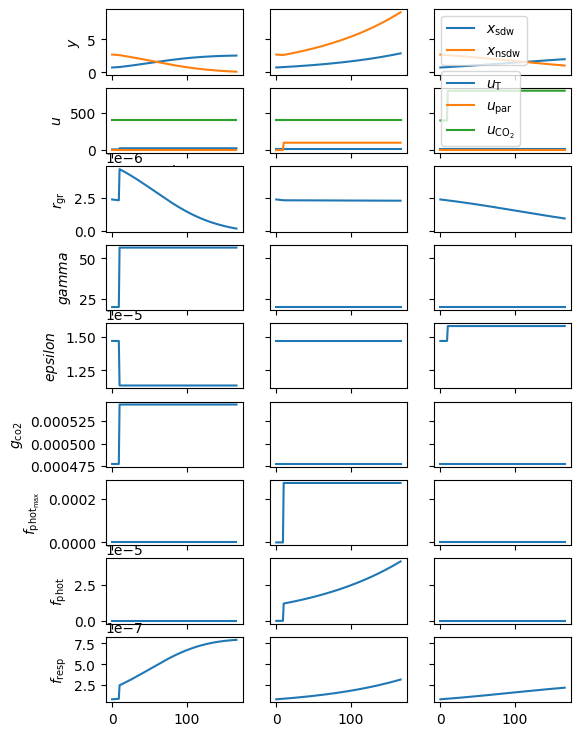

In [143]:
fig, axs = plt.subplots(
    nrows=2 + 7,
    ncols=len(u_max),
    figsize=(6, 9),
    sharex=True,
    sharey="row",
)

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

    # Replay simulation to get states
    xs = []
    for x, u in zip(y_out, u_out):
        _, _, x_ = _lettuce_growth_model(0, tuple(x), tuple(u))
        xs.append(x_)
    i = 0
    df = pd.DataFrame(xs)

    # Plot states
    plot_states(df, axs[2:, u_idx], u_idx == 0)

axs[0, 0].set_ylabel("$y$")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 2].legend()

plt.show()